<a href="https://colab.research.google.com/gist/francisco-perez-sorrosal/2f572610f85174c10987bbc770d7bdfc/copy-of-genai-workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neo4j Generative AI Workshop
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neo4j-product-examples/genai-workshop/blob/main/genai-workshop.ipynb)

This workshop will teach you how to use Neo4j for Graph-Powered Retrieval-Augmented Generation (GraphRAG) to enhance GenAI and improve response quality for real-world applications.

GenAI, despite its potential, faces challenges like hallucination and lack of domain knowledge. GraphRAG addresses these issues by combining vector search with knowledge graphs and data science techniques. This integration helps improve context, semantic understanding, and personalization, making Large Language Models (LLMs) more effective for critical applications.

We walk through an example that uses real-world customer and product data from a fashion, style, and beauty retailer. We show how you can use a knowledge graph to ground an LLM, enabling it to build tailored marketing content personalized to each customer based on their interests and shared purchase histories. We use Retrieval-Augmented Generation (RAG) to accomplish this,  specifically leveraging not just vector search but also graph pattern matching and graph machine learning to provide more relevant personalized results to customers. We call this graph-powered RAG approach “GraphRAG” for short.

This notebook walks through the process, including:
- Vector search
- Using graph patterns in Cypher to improve semantic search with context
- Further augmenting semantic search with knowledge graph inference & ML
- Building the LLM chain and demo app for generating content


Please see the companion notebooks for:
- [data-load.ipynb](https://github.com/neo4j-product-examples/genai-workshop/blob/main/data-load.ipynb)
    - Building the knowledge graph and generating text embeddings from scratch

- [genai-example-app-only](https://github.com/neo4j-product-examples/genai-workshop/blob/main/genai-workshop-app-only.ipynb)
    - Building the LLM chain and demo app for generating content
    

## Setup

### Some Logistics
1. Make a copy of this notebook in Colab by [clicking here](https://colab.research.google.com/github/neo4j-product-examples/genai-workshop/blob/main/genai-workshop.ipynb).
2. Run the pip install below to get the necessary dependencies.  this can take a while. Then run the following cell to import relevant libraries
3. We will be using [AuraDS](https://neo4j.com/cloud/platform/aura-graph-database/)  - Neo4j's fully managed Graph Database as a service and graph data science library - to deploy this demo.
- If you are participating in a Neo4j instructor-led training, you will be provided credentials to your own environment with pre-loaded data
- If you are running this notebook independently, you can load a [database dump](https://storage.googleapis.com/gds-training-materials/Version8_Jan2024/neo4j_genai_hnm.dump) in your own environment or on Neo4j Desktop, or load the data using the companion notebook [data-load.ipynb](https://github.com/neo4j-product-examples/genai-workshop/blob/main/data-load.ipynb)


In [ ]:
%%capture
%pip install sentence_transformers langchain langchain-openai langchain_community openai tiktoken python-dotenv gradio graphdatascience altair
%pip install "vegafusion[embed]"

In [ ]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from graphdatascience import GraphDataScience
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.graphs import Neo4jGraph
from langchain.prompts import PromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnableLambda
import gradio as gr

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 0)

### Setup Credentials and Environment Variables

There are two things you need here.
1. Credentials to a Neo4j database with Graph Data Science (AuraDS, Neo4j Desktop, or your own environment)
2. Your own [OpenAI API key](https://platform.openai.com/docs/quickstart?context=python).  You can use [this one](https://docs.google.com/document/d/19Lqjd0MqRs088KUVnd23ZrVU9G0OAg-53U72VrFwwms/edit) if you do not have one already.

To make this easy, you can write the credentials and env variables directly into the below cell.

Alternatively, if you like, you can use an environment file. This is a best practice for the future, but fine to skip for now.

In [ ]:
import os

# Neo4j
NEO4J_URI = 'neo4j+s://68c9e30e.databases.neo4j.io' #change this
NEO4J_PASSWORD = '68c-lake-tomato' #change this
NEO4J_USERNAME = 'neo4j'
AURA_DS = True

# AI
LLM = 'gpt-4o'
os.environ['OPENAI_API_KEY'] = '' #change this
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [ ]:
# You can skip this cell if not using a ws.env file - alternative to above
from dotenv import load_dotenv
import os

if os.path.exists('ws.env'):
     load_dotenv('ws.env', override=True)

     # Neo4j
     NEO4J_URI = os.getenv('NEO4J_URI')
     NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
     NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
     AURA_DS = eval(os.getenv('AURA_DS').title())

     # AI
     LLM = 'gpt-4o'
     OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [ ]:
OPENAI_API_KEY

''

## Connect to Neo4j

We will use the [Graph Data Science Python Client](https://neo4j.com/docs/graph-data-science-client/current/) to connect to Neo4j. This client makes it convenient to display results, as we will see later.  Perhaps more importantly, it allows us to easily run [Graph Data Science](https://neo4j.com/docs/graph-data-science/current/introduction/) algorithms from Python.

This client will only work if your Neo4j instance has Graph Data Science installed.  If not, you can still use the [Neo4j Python Driver](https://neo4j.com/docs/python-manual/current/) or use Langchain’s Neo4j Graph object that we will see later on.

In [ ]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to our setup
gds = GraphDataScience(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD),
    aura_ds=AURA_DS)

# Necessary if you enabled Arrow on the db - this is true for AuraDS
gds.set_database("neo4j")

Test your connection by running the below.  It should output your GDS version.

In [ ]:
gds.version()

'2.10.0'

## Knowledge Graph:

<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/hm-banner.png?raw=1" alt="summary" width="2000"/>

This workshop will leverage the [H&M Personalized Fashion Recommendations Dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data), a sample of real customer purchase data that includes rich information around products including names, types, descriptions, department sections, etc.

Below is the graph data model we will use:

<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/data-model.png?raw=1" alt="summary" width="1000"/>

If you are interested in how the knowledge graph was created from source data, see the companion notebook [data-load.ipynb](https://github.com/neo4j-product-examples/genai-workshop/blob/main/data-load.ipynb)

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: You can view the data model in Neo4j Query Browser with the statement: </span>

```cypher
CALL db.schema.visualization()
```

### Explore the Graph

Click on the node labels and relationship types on the left side of the browser window to explore the data and see what properties different node types have

You can then start to build out interesting query patterns to explore the data further

Some example queries you can copy paste into the browser:

```cypher
// How many Articles are in the database?
MATCH (a:Article) RETURN COUNT(DISTINCT a) as articleCount

// What are some example Articles in the database?
MATCH (a:Article) RETURN a.prodName as product, a.productTypeName AS type  LIMIT 5

// What is the most commonly purchased Article?
MATCH (c:Customer)-[r:PURCHASED]->(a:Article)
RETURN a.prodName as product, count(r) as purchases ORDER BY purchases DESC LIMIT 5                                

// What Department has the most purchases?
MATCH (c:Customer)-[r:PURCHASED]->(:Article)-[:FROM_DEPARTMENT]->(d:Department)
RETURN d.departmentName as department, count(r) as purchases ORDER BY purchases DESC LIMIT 5
```

## Vector Search

In this section, we will use text embeddings that were previously generated from product descriptions and demonstrate how to leverage the Neo4j vector index for vector search. We will also introduce the use of [LangChain](https://www.langchain.com/).


### Vector Search Using Cypher
Embeddings enable us to reduce multidimensional information into an embedded vector. In this case, we are using a semantic text embedding to support search for semantically similar products. This vector search provides advantages over traditional keyword search techniques as it defines similarity based on the meaning of the search terms and the returned items, rather than text similarity.

To prepare a vector search over products, we need to:
1. Convert product text descriptions into embeddings
2. Store these semantic embeddings as node properties in the database
3. Create a vector index to enable rapid search

These first steps were completed for you and are covered in [data-load.ipynb](https://github.com/neo4j-product-examples/genai-workshop/blob/main/data-load.ipynb)

To perform vector search, we need to:
1. Take the search prompt and convert it to an embedding query vector
2. Use similarity search with that new vector to pull semantically similar documents


The [Neo4j Vector Index](https://neo4j.com/docs/cypher-manual/current/indexes-for-vector-search/) enables efficient Approximate Nearest Neighbor (ANN) search with vectors. It uses the Hierarchical Navigable Small World (HNSW) algorithm.



Below is an example of converting a search prompt into a query vector. Again we can use Neo4j’s native integrations to call embedding APIs from Cypher. We use our same embedding model, OpenAI `text-embedding-ada-002` by default.


In [ ]:
#search_prompt = 'denim jeans, loose fit, high-waist'
search_prompt = 'denim jeans'
#generate embeddings
emb = gds.run_cypher('''
RETURN genai.vector.encode($searchPrompt, "OpenAI", {token:$token}) AS queryVector
''', params={'searchPrompt':search_prompt, 'token':OPENAI_API_KEY})
print(type(emb), len(emb))
print(emb)

<class 'pandas.core.frame.DataFrame'> 1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           queryVector
0  [-0.02218937873840332, -0.012347104959189892, -0.00806528888642788, -0.02785475365817547, -0.028012124821543694, 0.004937530495226383, -0.026674466207623482, -0.020117321982979774, -0.006101423874497414, -0.031579211354255676, 0.0024671258870512247, 0.006199780851602554, 0.0021704151295125484, -0.013691319152712822, -0.029900582507252693, 0.009127546101808548, 0.024890923872590065, -0.013520833104848862, 0.041073959320783615, -0.025140095502138138, -

To conduct vector search, we simply combine the above query with a call to the vector index to retrieve semantically similar documents.  

In [ ]:
#generate embeddings
vector_res = gds.run_cypher('''

//convert search prompt to query vector
WITH genai.vector.encode(
  $searchPrompt,
  "OpenAI",
  {token:$token}) AS queryVector

//find similar products via vector search with index
CALL db.index.vector.queryNodes("product_text_embeddings", 10, queryVector)
YIELD node AS product, score
RETURN product.productCode AS productCode,
    product.text AS text,
    score
''', params={'searchPrompt':search_prompt, 'token':OPENAI_API_KEY})

vector_res

,productCode,text,score
0,598423,Product-- Name: Night Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: High-waisted jeans in washed stretch denim with a zip fly and button and decorative zips on the waistband. Front and back pockets and skinny legs with a zip down the sides.,0.937683
1,252298,"Product-- Name: Didi denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Jeans in washed, stretch denim with hard-worn details, a regular waist, front and back pockets and skinny legs.",0.937683
2,652924,"Product-- Name: &DENIM Jeggings HW || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: High-waisted jeggings in stretch denim with a zip fly and button, fake front pockets and real back pockets.",0.933578
3,810170,"Product-- Name: Skinny denim (D) || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with fake front pockets, real back pockets and skinny legs. Wide ribbing at the waist for best fit over the tummy.",0.933105
4,727804,"Product-- Name: Didi HW Skinny denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with hard-worn details, a high waist, visible button fly, front and back pockets and skinny legs.",0.932678
5,620223,"Product-- Name: Beat denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted, ankle-length denim jeans with a zip fly and button, side pockets, welt back pockets and wide, straight legs with creases.",0.932632
6,698387,"Product-- Name: &DENIM+ Skinny Shaping HW || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket jeans in washed, stretch denim with a high waist, zip fly and button and skinny legs. Shaping – denim with a stretch function that holds in and shapes the waist, thighs and bum while keeping the jeans in shape.",0.931946
7,749656,"Product-- Name: &DENIM jen bermuda shorts || Type: Shorts || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket shorts in washed, stretch denim with a regular waist, zip fly and button, and sewn-in turn-ups at the hems. The cotton content of the shorts is partly recycled.",0.931931
8,571650,"Product-- Name: Taylor Fancy Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Low-rise, ankle-length jeans in washed stretch denim with front and back pockets, a zip fly and button, and skinny legs with raw-edge hems.",0.931412
9,469562,"Product-- Name: Skinny denim (1) || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with fake front pockets, real back pockets and skinny legs. Wide ribbing at the waist for best fit over the tummy.",0.930832


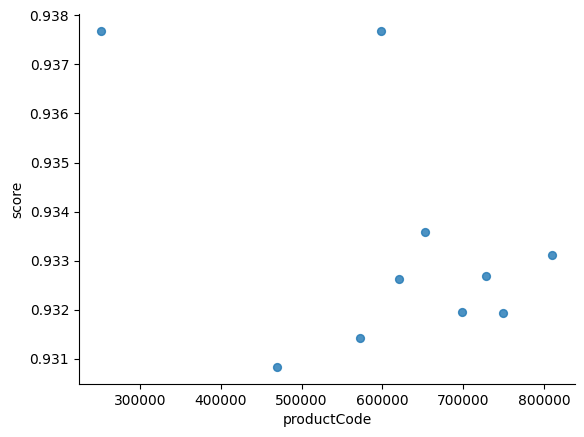

In [ ]:
# @title productCode vs score

from matplotlib import pyplot as plt
vector_res.plot(kind='scatter', x='productCode', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

While the above Cypher vector encoding calls are convenient, you have the freedom to generate embeddings externally from any model/API you want. You can then ingest them into Neo4j and use them for vector search.
Below is an example of generating an embedding externally and sending it as a query parameter, in this case for search, but you can also load embeddings in a similar matter.

**It is important to use the same embedding model for your search term that you used when embedding the data in your search space.**

In [ ]:
## Optional for workshop
# from langchain_openai import OpenAIEmbeddings
#
# embedding_model = OpenAIEmbeddings()
# embedding_dimension = 1536
#
# query_vector = embedding_model.embed_query(search_prompt)
# print(f'query vector length: {len(query_vector)}')
# print(f'query vector sample: {query_vector[:10]}')
# print(f'Result:')
#
# gds.run_cypher('''
# CALL db.index.vector.queryNodes("product_text_embeddings", 10, $queryVector)
# YIELD node AS product, score
# RETURN product.productCode AS productCode,
#     product.text AS text,
#     score
# ''', params={'queryVector': query_vector})

### Visualizing Results

Sometimes you may want to explore results outside of a table view. We can also visualize these search results in the graph. In this case - we will just see the product nodes returned

<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/search_results.png?raw=1" alt="summary" width="500"/>

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: You can view your results by copying the query printed below into Neo4j</span>

In [ ]:
print("MATCH (p:Product)\nWHERE p.productCode IN {productList}\nRETURN p".format(productList= list(vector_res.productCode)))

MATCH (p:Product)
WHERE p.productCode IN [598423, 252298, 652924, 810170, 727804, 620223, 698387, 749656, 571650, 469562]
RETURN p


### Vector Search Using Langchain

We can also do this vector search with [LangChain](https://www.langchain.com/), a recommended approach as we seek to integrate LLM chains going forward.  To do this, we use the `Neo4jVector` class and call the below method to set up from an existing index in the graph.

In [ ]:
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings()
embedding_dimension = 1536

kg_vector_search = Neo4jVector.from_existing_index(
    embedding=embedding_model,
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='product_text_embeddings')

Langchain can handle embedding the query vector and retrieving data from Neo4j behind the scenes, making our lives easier.  Langchain uses a similar query as above and retrieves the `text` property we set for each Product node.

In [ ]:
# Instead of 2 steps (Embed search term, perform vector search)
# LangChain handles the orchestration for us in a single line of code
res = kg_vector_search.similarity_search(search_prompt, k=10)
res
# Visualize as a dataframe
pd.DataFrame([{'document': d.page_content, 'prod_type': d.metadata['garmentGroupName']} for d in res])

,document,prod_type
0,Product-- Name: Night Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: High-waisted jeans in washed stretch denim with a zip fly and button and decorative zips on the waistband. Front and back pockets and skinny legs with a zip down the sides.,Dresses Ladies
1,"Product-- Name: Didi denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Jeans in washed, stretch denim with hard-worn details, a regular waist, front and back pockets and skinny legs.",Dresses Ladies
2,"Product-- Name: &DENIM Jeggings HW || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: High-waisted jeggings in stretch denim with a zip fly and button, fake front pockets and real back pockets.",Trousers Denim
3,"Product-- Name: Skinny denim (D) || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with fake front pockets, real back pockets and skinny legs. Wide ribbing at the waist for best fit over the tummy.",Trousers
4,"Product-- Name: Didi HW Skinny denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with hard-worn details, a high waist, visible button fly, front and back pockets and skinny legs.",Trousers
5,"Product-- Name: Beat denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted, ankle-length denim jeans with a zip fly and button, side pockets, welt back pockets and wide, straight legs with creases.",Trousers
6,"Product-- Name: &DENIM+ Skinny Shaping HW || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket jeans in washed, stretch denim with a high waist, zip fly and button and skinny legs. Shaping – denim with a stretch function that holds in and shapes the waist, thighs and bum while keeping the jeans in shape.",Trousers Denim
7,"Product-- Name: &DENIM jen bermuda shorts || Type: Shorts || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket shorts in washed, stretch denim with a regular waist, zip fly and button, and sewn-in turn-ups at the hems. The cotton content of the shorts is partly recycled.",Trousers Denim
8,"Product-- Name: Taylor Fancy Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Low-rise, ankle-length jeans in washed stretch denim with front and back pockets, a zip fly and button, and skinny legs with raw-edge hems.",Dresses Ladies
9,"Product-- Name: Skinny denim (1) || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with fake front pockets, real back pockets and skinny legs. Wide ribbing at the waist for best fit over the tummy.",Trousers


### Try Yourself

Experiment with your own prompts!

In [ ]:
res = kg_vector_search.similarity_search('not a short', k=10)
print(res)
pd.DataFrame([{'document': d.page_content, 'prod_type': d.metadata['productTypeName']} for d in res])

[Document(metadata={'prodName': 'EVERT SHORTS', 'garmentGroupName': 'Shorts', 'garmentGroupNo': 1025, 'productCode': 474461, 'productTypeName': 'Shorts', 'productTypeNo': 274, 'detailDesc': 'Chino shorts in washed cotton poplin with a zip fly, side pockets, welt back pockets with a button and legs with creases.', 'productGroupName': 'Garment Lower body', 'url': 'https://representative-domain/product/474461'}, page_content='Product-- Name: EVERT SHORTS || Type: Shorts || Group: Garment Lower body || Garment Type: Shorts || Description: Chino shorts in washed cotton poplin with a zip fly, side pockets, welt back pockets with a button and legs with creases.'), Document(metadata={'prodName': 'MALCOLM SHORTS', 'garmentGroupName': 'Jersey Basic', 'garmentGroupNo': 1002, 'productCode': 582011, 'productTypeName': 'Shorts', 'productTypeNo': 274, 'detailDesc': 'Knee-length shorts in sweatshirt fabric with an elasticated drawstring waist and side pockets.', 'productGroupName': 'Garment Lower body

,document,prod_type
0,"Product-- Name: EVERT SHORTS || Type: Shorts || Group: Garment Lower body || Garment Type: Shorts || Description: Chino shorts in washed cotton poplin with a zip fly, side pockets, welt back pockets with a button and legs with creases.",Shorts
1,Product-- Name: MALCOLM SHORTS || Type: Shorts || Group: Garment Lower body || Garment Type: Jersey Basic || Description: Knee-length shorts in sweatshirt fabric with an elasticated drawstring waist and side pockets.,Shorts
2,"Product-- Name: Shorts Straight Long (1) || Type: Shorts || Group: Garment Lower body || Garment Type: Shorts || Description: 5-pocket, knee-length shorts in washed denim with a button fly and sewn-in turn-ups at the hems.",Shorts
3,"Product-- Name: Mandy shorts print || Type: Shorts || Group: Garment Lower body || Garment Type: Shorts || Description: Wide shorts in a viscose weave with a regular, elasticated waist, pleats at the front and side pockets.",Shorts
4,"Product-- Name: Mandy || Type: Shorts || Group: Garment Lower body || Garment Type: Shorts || Description: Short, high-waisted shorts in a viscose weave with pleats at the top, wide elastication at the back of the waist, and side pockets.",Shorts
5,Product-- Name: Portman || Type: Dress || Group: Garment Full body || Garment Type: Dresses Ladies || Description: Short dress in woven fabric with a small stand-up collar and 3/4-length sleeves with flared cuffs.,Dress
6,"Product-- Name: Vovve shorts || Type: Shorts || Group: Garment Lower body || Garment Type: Trousers || Description: Wide, high-waisted shorts in woven fabric with a sewn-in tie belt and pleats at the top. Fly with a concealed zip, side pockets and fake welt back pockets.",Shorts
7,"Product-- Name: Fancy Dress || Type: Dress || Group: Garment Full body || Garment Type: Dresses Ladies || Description: Short, fitted dress in sturdy jersey with a V-neck and long sleeves.",Dress
8,"Product-- Name: Wanda Shorts || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Short shorts in woven fabric with a high paper bag waist with wide elastication, a fake fly and pockets in the side seams with metal details.",Trousers
9,"Product-- Name: Richard fancy shorts || Type: Shorts || Group: Garment Lower body || Garment Type: Jersey Fancy || Description: Shorts in lightweight sweatshirt fabric with an elasticated drawstring waist, side pockets and an open back pocket. Sewn-in turn-ups at the hems with the reverse side showing.",Shorts


## Semantic Search with Context (Graph Patterns)
__Using Graph Patterns to Improve Context in Search & Retrieval__

Above, we saw how you can use the vector index to find semantically similar products in user searches.  This is a powerful tool; however, it can be improved upon.  We have more data in this dataset that could be helpful in making recommendations - like customer purchase history.

Furthermore, some search
prompts, like "denim jeans", are very general and can match a large number of products, many of which won't be relevant to the specific user conducting the search.

We have a rich knowledge graph full of customer information; let's see how to leverage it to improve search experience and create more personalized search results.

### Explore in Neo4j
To understand how to better leverage the data in our graph, let's explore in Neo4j Browser/Query view on our Aura instance.

We can also use Cypher to sample the graph.

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: Run the below query in Browser and explore the results </span>

```cypher
MATCH (p:Product)<-[v:VARIANT_OF]-(a:Article)<-[t:PURCHASED]-(c:Customer)
RETURN * LIMIT 150
```

You can combine this query pattern with the products that resulted from our vector search in the printed cypher query in the next cell

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: See the connections between vector search results with the printed query result below </span>

In [ ]:
print("MATCH (p:Product)<-[v:VARIANT_OF]-(a:Article)<-[t:PURCHASED]-(c:Customer) \nWHERE p.productCode IN {productList}\nRETURN *".format(productList= list(vector_res.productCode)))

MATCH (p:Product)<-[v:VARIANT_OF]-(a:Article)<-[t:PURCHASED]-(c:Customer) 
WHERE p.productCode IN [598423, 252298, 652924, 810170, 727804, 620223, 698387, 749656, 571650, 469562]
RETURN *


### Graph Connections!
You should get something that looks like the below.  Notice the multi-hop connections between customers based on purchases. This is valuable information encoded in our graph!

<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/sample-query.png?raw=1" alt="summary" width="1000"/>

#### Understanding Shared Customer Behavior

Now let's consider a single customer's purchase history.

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: We will choose the below customer by setting customerId as a parameter. </span>

```cypher
:params {customerId:'daae10780ecd14990ea190a1e9917da33fe96cd8cfa5e80b67b4600171aa77e0'}
```

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: Then we can run the below Cypher to pull our target customers's purchase history </span>


```cypher
MATCH(c:Customer {customerId: $customerId})-[t:PURCHASED]->(:Article)
-[:VARIANT_OF]->(p:Product)
RETURN p.productCode AS productCode,
    p.prodName AS prodName,
    p.productTypeName AS productTypeName,
    p.garmentGroupName AS garmentGroupName,
    p.detailDesc AS detailDesc,
    t.tDat AS purchaseDate
ORDER BY t.tDat DESC
```
Expected results:
<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/purchase-history.png?raw=1" alt="summary" width="1000"/>

These purchases are ordered by transaction date. The most recent purchases should be the "Tove Top" and the "Rosemary Dress".

Now let's consider just the latest products in the above list and see what else we could recommend to customers who liked them.

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: The following Cypher query provides potential answers by finding the most popular products among customers who purchased these. </span>

```cypher
//pull the latest purchases
MATCH(c:Customer {customerId: $customerId})-[t:PURCHASED]->()
WITH max(t.tDat) AS latestPurchases
//find related products based on customer purchases
MATCH(c:Customer {customerId: $customerId})-[:PURCHASED {tDat: latestPurchases}]->(:Article)<-[:PURCHASED]-(:Customer)-[:PURCHASED]->(:Article)
    -[:VARIANT_OF]->(p:Product)
RETURN p.productCode AS productCode,
    p.prodName AS prodName,
    p.productTypeName AS productTypeName,
    p.garmentGroupName AS garmentGroupName,
    count(*) AS commonPurchaseScore,
    p.detailDesc AS detailDesc
ORDER BY commonPurchaseScore DESC
```

Expected results:
<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/related-products.png?raw=1" alt="summary" width="1000"/>

__You will see that some of the above results seem intuitive, like we see other products of the type "Jersey Fancy" which our customer has previously purchased...but not all of them...and that is exactly the point!
There is information encoded inside the knowledge graph about customer preferences that isn't inferable from the product text documents.__

__This is one example of where enterprise-specific data, expressed as structured relationships, contains critical information that is impossible to find elsewhere. This is why, for many real-world applications, you should consider backing semantic search and GenAI with Knowledge Graphs.__

Now let’s see how to apply this pattern in our semantic search and retrieval!

### Personalizing Results Based on Customer Behavior in the Graph

As we saw in Browser, an important piece of information expressed in this graph, but not directly in the product documents and text embeddings, is customer purchasing behavior.  We saw that we can use graph patterns in Cypher to extract insights from these. Now that we know how this pattern works, we can apply it to our semantic search to make results more personalized.

To do this, we append a MATCH statement to the end of our initial vector search query.  Basically, once the product documents are returned, we can re-calculate how they would score according to the query above and use that to re-rank the search results.

Langchain makes this easy by allowing for a `retrieval_query` argument where we can put in the pattern we need.

In [ ]:
kg_personalized_search = Neo4jVector.from_existing_index(
    embedding=embedding_model,
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='product_text_embeddings',
    retrieval_query="""
    WITH node AS product, score AS searchScore

    OPTIONAL MATCH(product)<-[:VARIANT_OF]-(:Article)<-[:PURCHASED]-(:Customer)
    -[:PURCHASED]->(a:Article)<-[:PURCHASED]-(:Customer {customerId: $customerId})

    WITH count(a) AS purchaseScore, product.text AS text, searchScore, product.productCode AS productCode
    RETURN text,
        (1+purchaseScore)*searchScore AS score,
        {productCode: productCode, purchaseScore:purchaseScore, searchScore:searchScore} AS metadata
    ORDER BY purchaseScore DESC, searchScore DESC LIMIT 15
    """)

The query expands from the results of the pure vector search to prioritize products that similar customers purchased, with the new combined __score__ reflecting both the text embedding similarity and number of purchases in common with our target customer

🎉 This allows us to rank results by BOTH semantic similarity and customer behavior! 🎉

Now let's run it to see if/how our results have changed.

In [ ]:
vector_res

,productCode,text,score
0,598423,Product-- Name: Night Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: High-waisted jeans in washed stretch denim with a zip fly and button and decorative zips on the waistband. Front and back pockets and skinny legs with a zip down the sides.,0.937683
1,252298,"Product-- Name: Didi denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Jeans in washed, stretch denim with hard-worn details, a regular waist, front and back pockets and skinny legs.",0.937683
2,652924,"Product-- Name: &DENIM Jeggings HW || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: High-waisted jeggings in stretch denim with a zip fly and button, fake front pockets and real back pockets.",0.933578
3,810170,"Product-- Name: Skinny denim (D) || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with fake front pockets, real back pockets and skinny legs. Wide ribbing at the waist for best fit over the tummy.",0.933105
4,727804,"Product-- Name: Didi HW Skinny denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with hard-worn details, a high waist, visible button fly, front and back pockets and skinny legs.",0.932678
5,620223,"Product-- Name: Beat denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted, ankle-length denim jeans with a zip fly and button, side pockets, welt back pockets and wide, straight legs with creases.",0.932632
6,698387,"Product-- Name: &DENIM+ Skinny Shaping HW || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket jeans in washed, stretch denim with a high waist, zip fly and button and skinny legs. Shaping – denim with a stretch function that holds in and shapes the waist, thighs and bum while keeping the jeans in shape.",0.931946
7,749656,"Product-- Name: &DENIM jen bermuda shorts || Type: Shorts || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket shorts in washed, stretch denim with a regular waist, zip fly and button, and sewn-in turn-ups at the hems. The cotton content of the shorts is partly recycled.",0.931931
8,571650,"Product-- Name: Taylor Fancy Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Low-rise, ankle-length jeans in washed stretch denim with front and back pockets, a zip fly and button, and skinny legs with raw-edge hems.",0.931412
9,469562,"Product-- Name: Skinny denim (1) || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: Jeans in washed, stretch denim with fake front pockets, real back pockets and skinny legs. Wide ribbing at the waist for best fit over the tummy.",0.930832


In [ ]:
vector_kg_res

,productCode,document,searchScore,purchaseScore
0,706016,"Product-- Name: Jade HW Skinny Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets and super-skinny legs.",0.927429,11
1,777038,"Product-- Name: Bono NW slim denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: 5-pocket, ankle-length jeans in washed slightly stretch denim with a high waist, zip fly and button and tapered legs.",0.926147,8
2,448509,"Product-- Name: Perrie Slim Mom Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: 5-pocket, ankle-length jeans in washed, sturdy cotton denim with a high waist, button fly and slim, straight legs with raw-edge hems.",0.923859,5
3,539723,"Product-- Name: Jade Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets and super-skinny legs.",0.929459,3
4,599489,"Product-- Name: Straight H.W || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket, high-waisted straight jeans in washed denim with hard-worn details and a zip fly and button.",0.924347,2
...,...,...,...,...
10,779659,"Product-- Name: Perrie Fancy Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: 5-pocket, ankle-length jeans in washed denim with decorative V-shaped seams at the top. Slightly looser fit with an extra high waist, zip fly and button and tapered legs.",0.923660,1
11,557241,"Product-- Name: Vintage Slim H.W || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket ankle-length jeans in washed denim with a high waist, button fly and slim legs with sparkly stones at the front.",0.923080,1
12,598423,Product-- Name: Night Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: High-waisted jeans in washed stretch denim with a zip fly and button and decorative zips on the waistband. Front and back pockets and skinny legs with a zip down the sides.,0.937683,0
13,252298,"Product-- Name: Didi denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Jeans in washed, stretch denim with hard-worn details, a regular waist, front and back pockets and skinny legs.",0.937683,0


In [ ]:
CUSTOMER_ID = "daae10780ecd14990ea190a1e9917da33fe96cd8cfa5e80b67b4600171aa77e0"

res = kg_personalized_search.similarity_search(search_prompt, k=100, params={'customerId': CUSTOMER_ID})

# Visualize as a dataframe
vector_kg_res = pd.DataFrame([{'productCode': d.metadata['productCode'],
               'document': d.page_content,
               'searchScore': d.metadata['searchScore'],
               'purchaseScore': d.metadata['purchaseScore']} for d in res])

To compare our results, we'll merge our `vector-only` results dataframe and our `vector+knowledge graph traversal` results dataframe on product code and capture the overlapping product row indexes in a new column "vector_rank"

In [ ]:
vector_res.reset_index(names='vector_rank', inplace=True)

As you can see - the results have changed quite a bit! These results are specifically tailored to our target customer based on their preferences, rather than just being semantically related to our search term

In [ ]:
vector_kg_res.merge(vector_res[['productCode', 'vector_rank']], on='productCode', how='left')

,productCode,document,searchScore,purchaseScore,vector_rank
0,706016,"Product-- Name: Jade HW Skinny Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets and super-skinny legs.",0.927429,11,NaN
1,777038,"Product-- Name: Bono NW slim denim || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: 5-pocket, ankle-length jeans in washed slightly stretch denim with a high waist, zip fly and button and tapered legs.",0.926147,8,NaN
2,448509,"Product-- Name: Perrie Slim Mom Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: 5-pocket, ankle-length jeans in washed, sturdy cotton denim with a high waist, button fly and slim, straight legs with raw-edge hems.",0.923859,5,NaN
3,539723,"Product-- Name: Jade Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets and super-skinny legs.",0.929459,3,NaN
4,599489,"Product-- Name: Straight H.W || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket, high-waisted straight jeans in washed denim with hard-worn details and a zip fly and button.",0.924347,2,NaN
...,...,...,...,...,...
10,779659,"Product-- Name: Perrie Fancy Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: 5-pocket, ankle-length jeans in washed denim with decorative V-shaped seams at the top. Slightly looser fit with an extra high waist, zip fly and button and tapered legs.",0.923660,1,NaN
11,557241,"Product-- Name: Vintage Slim H.W || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket ankle-length jeans in washed denim with a high waist, button fly and slim legs with sparkly stones at the front.",0.923080,1,NaN
12,598423,Product-- Name: Night Denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: High-waisted jeans in washed stretch denim with a zip fly and button and decorative zips on the waistband. Front and back pockets and skinny legs with a zip down the sides.,0.937683,0,0.0
13,252298,"Product-- Name: Didi denim || Type: Trousers || Group: Garment Lower body || Garment Type: Dresses Ladies || Description: Jeans in washed, stretch denim with hard-worn details, a regular waist, front and back pockets and skinny legs.",0.937683,0,1.0


## Augmenting Semantic Search with Knowledge Graph Inference & ML

We saw above how to use graph pattern matching to personalize semantic search and make it more contextually relevant.

In addition to this, we also have [Graph Data Science algorithms and machine learning](https://neo4j.com/docs/graph-data-science/current/introduction/) which allows you to enrich your knowledge graph with additional properties, relationships, and graph metrics. These can, in turn, be leveraged in search and retrieval to improve and augment results.

We will walk through an example of this below, where we use Graph Data Science to augment retrieval with additional product recommendations.


Below, we use graph machine learning to create relationships that can help us make personalized recommendations based on purchase history.


We do this by leveraging Node Embeddings with K-Nearest Neighbor (KNN). Specifically we:
1. Use Node embeddings to encode the similarity between articles based on shared customer search history
2. Take those node embeddings as input to KNN, an unsupervised learning technique, to link the most similar products together with a "CUSTOMERS_ALSO_LIKE" relationship.
3. We can then use Cypher patterns at query time to grab recommended items based on a customer's recent purchase history.
This process helps scale memory-based recommendation techniques to larger datasets.

In [ ]:
%%time
#clear past GDS analysis in the case of re-running
def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        g = gds.graph.get(g_name)
        g.drop()

clear_all_graphs()

gds.run_cypher('''
    MATCH(:Article)-[r:CUSTOMERS_ALSO_LIKE]->()
    CALL {
        WITH r
        DELETE r
    } IN TRANSACTIONS OF 1000 ROWS
    ''')

# graph projection - project co-purchase graph into analytics workspace
gds.run_cypher('''
  MATCH (a1:Article)<-[:PURCHASED]-(:Customer)-[:PURCHASED]->(a2:Article)
  WITH gds.graph.project("proj", a1, a2,
       {relationshipType: "COPURCHASE"}) AS g
  RETURN g.graphName
   ''')
# This results in an in-memory graph with the structure (Article)-[:COPURCHASE]->(Article)

g = gds.graph.get("proj")

# create FastRP node embeddings
gds.fastRP.mutate(g, mutateProperty='nodeEmbedding', embeddingDimension=128, randomSeed=7474, concurrency=4, iterationWeights=[0.0, 1.0, 1.0])

# write embeddings back to database to introspect later
gds.graph.writeNodeProperties(g, ['nodeEmbedding'])

CPU times: user 100 ms, sys: 8.93 ms, total: 109 ms
Wall time: 6.52 s


,0
writeMillis,420
graphName,proj
nodeProperties,[nodeEmbedding]
propertiesWritten,13296
configuration,"{'jobId': '687b6784-7108-49d3-b9e2-cb7252f6fa2f', 'logProgress': True, 'concurrency': 4, 'sudo': False, 'writeToResultStore': False, 'writeConcurrency': 4}"


#### Explore Node Embeddings
We applied [FastRP](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/) to capture the topological structure of customer copurchase behavior. These embeddings will enable us to evaluate similarity between node embeddings to understand whether product articles are likely to be purchased together, and persist relationships we can use to enhance our recommendations

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: Use the following query to view node embedding properties in the database </span>

``` cypher
MATCH (p:Product)<-[:VARIANT_OF]-(a:Article)-[:FROM_DEPARTMENT]-(d)
RETURN a.articleId AS articleId,
    p.prodName AS productName,
    p.productTypeName AS productTypeName,
    d.departmentName AS departmentName,
    d.sectionName AS sectionName,
    p.detailDesc AS detailDesc,
    a.nodeEmbedding AS nodeEmbedding LIMIT 5
```

### K-Nearest Neighbors (KNN) Relationships

Now, we can do our similarity inference with [K-Nearest Neighbors algorithm (KNN)](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) - writing results back directly to the database.

In [ ]:
# draw KNN
knn_stats = gds.knn.write(g, nodeProperties=['nodeEmbedding'],
                  writeRelationshipType='CUSTOMERS_ALSO_LIKE', writeProperty='score',
                  sampleRate=1.0, initialSampler='randomWalk', concurrency=1, similarityCutoff=0.75, randomSeed=7474)

# clear graph projection once done
g.drop()

# output knn stats
knn_stats

K-Nearest Neighbours:   0%|          | 0/100 [00:00<?, ?%/s]

,0
ranIterations,7
didConverge,True
nodePairsConsidered,7068227
preProcessingMillis,0
computeMillis,3098
...,...
postProcessingMillis,0
nodesCompared,13296
relationshipsWritten,125497
similarityDistribution,"{'min': 0.750030517578125, 'p5': 0.8716926574707031, 'max': 1.000007629394531, 'p99': 1.0000038146972656, 'p1': 0.7865028381347656, 'p10': 0.908966064453125, 'p90': 1.0000038146972656, 'p50': 0.9999923706054688, 'p25': 0.9821624755859375, 'p75': 0.9999961853027344, 'p95': 1.0000038146972656, 'mean': 0.9777231618807255, 'p100': 1.0000038146972656, 'stdDev': 0.04617295721957434}"


We now have a new persisted relationship capturing the similarity between articles based on customer preferences inferred from their product
copurchase behavior.

<span style="color:DarkBlue; background-color:LightCyan">
<b>Database Tip</b>: Refresh your browser window and click on the new relationship CUSTOMERS_ALSO_LIKE on the left side panel to see the inferred relationship from FastRP and KNN </span>

<img src="https://github.com/neo4j-product-examples/genai-workshop/blob/main/img/CUSTOMERS_ALSO_LIKE.png?raw=1" alt="summary" width="1000"/>


### Personalized Recommendations

Now, let's construct a KG store to retrieve recommendations for a user using our new CUSTOMERS_ALSO_LIKE relationship.  This need not be based on a user prompt or vector search. Instead, we will make it purely based on purchase history.

In [ ]:
from langchain.graphs import Neo4jGraph

kg = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

res = kg.query('''
    MATCH(:Customer {customerId:$customerId})-[:PURCHASED]->(:Article)
    -[r:CUSTOMERS_ALSO_LIKE]->(:Article)-[:VARIANT_OF]->(product)
    RETURN product.productCode AS productCode,
        product.prodName AS prodName,
        product.productTypeName AS productType,
        product.text AS document,
        sum(r.score) AS recommenderScore
    ORDER BY recommenderScore DESC LIMIT $k
    ''', params={'customerId': CUSTOMER_ID, 'k':15})

#visualize as dataframe. result is list of dict
pd.DataFrame(res)

,productCode,prodName,productType,document,recommenderScore
0,569974,DONT USE ROLAND HOOD,Hoodie,"Product-- Name: DONT USE ROLAND HOOD || Type: Hoodie || Group: Garment Upper body || Garment Type: Jersey Basic || Description: Top in sweatshirt fabric with a lined drawstring hood, kangaroo pocket, long raglan sleeves and ribbing at the cuffs and hem.",28.685492
1,656401,PASTRY SWEATER,Sweater,"Product-- Name: PASTRY SWEATER || Type: Sweater || Group: Garment Upper body || Garment Type: Knitwear || Description: Jumper in soft, textured-knit cotton with long raglan sleeves and ribbing around the neckline, cuffs and hem.",17.892415
2,642498,Bubble Bum Bandeau (1),Bikini top,"Product-- Name: Bubble Bum Bandeau (1) || Type: Bikini top || Group: Swimwear || Garment Type: Swimwear || Description: Fully lined bandeau bikini top with padded cups and removable inserts. Detachable ties at the back of the neck, ties at the back, side support and a silicone trim at the top.",16.789007
3,660519,Haven back detail,Bra,"Product-- Name: Haven back detail || Type: Bra || Group: Underwear || Garment Type: Under-, Nightwear || Description: Push-up bra in lace and mesh with underwired, moulded, padded cups for a larger bust and fuller cleavage. Lace racer back, narrow adjustable shoulder straps, a wide mesh strap at the back and a metal fastener at the front.",15.896369
4,662328,Survivor,Blouse,"Product-- Name: Survivor || Type: Blouse || Group: Garment Upper body || Garment Type: Blouses || Description: Straight-cut blouse in a crêpe weave with a collar, concealed buttons down the front and fake flap front pockets. Yoke with a pleat at the back, long sleeves with pleats and buttoned cuffs, and a straight cut hem with slits in the sides.",14.789096
...,...,...,...,...,...
10,682848,Skinny RW Ankle Milo Zip,Trousers,"Product-- Name: Skinny RW Ankle Milo Zip || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers Denim || Description: 5-pocket, ankle-length jeans in washed stretch denim with hard-worn details, a regular waist, zip fly and button, and skinny legs with a zip at the hems. The jeans are made partly from recycled cotton.",9.999887
11,598806,Dixie tee,T-shirt,Product-- Name: Dixie tee || Type: T-shirt || Group: Garment Upper body || Garment Type: Jersey Fancy || Description: Short top in soft cotton jersey with short sleeves. Contrasting colour trims around the neckline and sleeves.,9.892483
12,752193,Banks,Hoodie,"Product-- Name: Banks || Type: Hoodie || Group: Garment Upper body || Garment Type: Jersey Basic || Description: Long-sleeved top in sweatshirt fabric made from a cotton blend with a double-layered hood, gently dropped shoulders and ribbing at the cuffs and hem. Soft brushed inside.",8.896614
13,606711,Rylee flatform,Heeled sandals,"Product-- Name: Rylee flatform || Type: Heeled sandals || Group: Shoes || Garment Type: Shoes || Description: Sandals with imitation suede straps, an elastic heel strap and wedge heels. Satin insoles and thermoplastic rubber (TPR) soles. Platform front 2 cm, heel 6 cm.",7.999907


## LLM For Generating Grounded Content

Let's use an LLM to automatically generate content for targeted marketing campaigns grounded with our knowledge graph using the above tools.
Here is a quick example for generating promotional messages, but you can create all sorts of content with this!

For our first message, let's consider a scenario where a user recently searched for products, but perhaps didn't commit to a purchase yet. We now want to send a message to promote relevant products.

In [ ]:
# Import relevant libraries
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import StrOutputParser

#Instantiate LLM
llm = ChatOpenAI(temperature=0, model_name=LLM, streaming=True)

### Create Knowledge Graph Stores for Retrieval

To ground our content generation, we need to define retrievers to pull information from our knowledge graph.  Let's make two stores:
1. Personalized Search Retriever (`kg_personalized_search`): Based on recent customer searches and purchase history, pull relevant products.
2. Recommendations retriever (`kg_recommendations_app`): Based on our Graph ML, what else can we recommend to them that pairs with their interests?


In [ ]:
    # MATCH(:Customer {customerId:$customerId})-[:PURCHASED]->(:Article)
    # -[r:CUSTOMERS_ALSO_LIKE]->(:Article)-[:VARIANT_OF]->(product)
    # RETURN product.productCode AS productCode,
    #     product.prodName AS prodName,
    #     product.productTypeName AS productType,
    #     product.text AS document,
    #     sum(r.score) AS recommenderScore
    # ORDER BY recommenderScore DESC LIMIT $k
    # ''', params={'customerId': CUSTOMER_ID, 'k':15})


# We will use a mock URL for our sources in the metadata
kg_personalized_search_store = Neo4jVector.from_existing_index(
        embedding=embedding_model,
        url=NEO4J_URI,
        username=NEO4J_USERNAME,
        password=NEO4J_PASSWORD,
        index_name='product_text_embeddings',
        retrieval_query="""
        WITH node AS product, score AS searchScore

        OPTIONAL MATCH(product)<-[:VARIANT_OF]-(:Article)<-[:PURCHASED]-(:Customer)
        -[:PURCHASED]->(a:Article)<-[:PURCHASED]-(:Customer {customerId: $customerId})
        WITH count(a) AS purchaseScore, product, searchScore
        RETURN product.text + '\nurl: ' + product.url  AS text,
            (1.0+purchaseScore)*searchScore AS score,
            {source: product.url} AS metadata
        ORDER BY purchaseScore DESC, searchScore DESC LIMIT 10
    """
    )

# This will be a function so we can change per customer id
def kg_personalized_search(search_prompt, customer_id, k=100):
    docs = kg_personalized_search_store.similarity_search(search_prompt, k, params={'customerId': customer_id})
    return "\n\n".join([d.page_content for d in docs])

# Use the same personalized recommendations as above but with a smaller limit
def kg_recommendations_app(customer_id, k=30):
    res = kg.query("""
    MATCH(:Customer {customerId:$customerId})-[:PURCHASED]->(:Article)
    -[r:CUSTOMERS_ALSO_LIKE]->(:Article)-[:VARIANT_OF]->(product)
    RETURN product.text + '\nurl: ' + product.url   AS text,
        sum(r.score) AS recommenderScore
    ORDER BY recommenderScore DESC LIMIT $k
    """, params={'customerId': customer_id, 'k':k})

    return "\n\n".join([d['text'] for d in res])

### Prompt Engineering

Now let's define our prompt. We will accept multiple parameters and provide detailed instructions to the LLM to condition the response based of retrieved data, customer interests, and time of year.


In [ ]:
prompt = PromptTemplate.from_template('You are a personal assistant named Sally '
'for a fashion, home, and beauty company called HRM.'
'write an engaging email to {customerName}, one of your customers, '
'to promote and summarize products relevant for them given: '
'- The current season / time of year: {timeOfYear}'
'- Recent searches/interests: {customerInterests}'
'Please only mention the products listed below. '
'Do not come up with or add any new products to the list.'
'Each product comes with an https `url` field. '
'Make sure to provide that https url with descriptive name text '
'in markdown for each product.'
'''

# RelevantProducts:
These are products from the HRM store the customer may be interested in based
on their recent searches/interests: {customerInterests}
{searchProds}

# Customer May Also Be Interested In the following
The below candidates are recommended based on the shared purchase patterns of
other customers in the HRM database.
Select the best 4 to 5 product subset from the context that best match the
time of year: {timeOfYear} and to pair with the RelevantProducts above.
For example, even if scarfs are listed here, they may not be appropriate for a
summer time of year so best not to include those.
{recProds}
''')

### Create a Chain

Now let's put a chain together that will leverage the retrievers, prompt, and LLM model. This is where Langchain shines, putting RAG together in a simple way.

In addition to the personalized search and recommendations context, we will allow for some other parameters.

1. `timeOfYear`: The time of year as a date, season, month, etc. so the LLM can tailor language and choose relevant products appropriately.
2. `customerName`: Ordinarily, this can be pulled from the DB, but it has been scrubbed to maintain anonymity, so we will provide our own name here.

You can potentially add other creative parameters here to help the LLM write relevant messages.


In [ ]:
chain = ({'searchProds': (lambda x:kg_personalized_search(x['customerInterests'], x['customerId'])),
          'recProds': (lambda x:kg_recommendations_app(x['customerId'])),
          'customerName': lambda x:x['customerName'],
          'timeOfYear': lambda x:x['timeOfYear'],
          "customerInterests":  lambda x:x['customerInterests']}
         | prompt
         | llm
         | StrOutputParser())

### Example Runs

In [ ]:
search_prompt

'denim jeans'

In [ ]:
print(chain.invoke({'customerInterests':search_prompt,
                    'customerId':CUSTOMER_ID,
                    'customerName':'Alex Smith',
                    'timeOfYear':'Jun, 2024'}))

Subject: Discover Your Perfect Denim and Summer Essentials at HRM!

Dear Alex,

I hope this email finds you well and enjoying the start of summer! As the days get warmer, it's the perfect time to refresh your wardrobe with some stylish and comfortable pieces. Based on your recent interest in denim jeans, I’ve curated a selection of our top denim products along with a few summer essentials that I think you'll love.

### Denim Delights

1. **[Jade HW Skinny Denim TRS](https://representative-domain/product/706016)**
   - High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets, and super-skinny legs.

2. **[Bono NW Slim Denim](https://representative-domain/product/777038)**
   - 5-pocket, ankle-length jeans in washed slightly stretch denim with a high waist, zip fly and button, and tapered legs.

3. **[Perrie Slim Mom Denim TRS](https://representative-domain/product/448509)**
   - 5-pocket, ankle-length jeans in washed, sturdy cotton

#### Inspecting the Prompt Sent to the LLM
In the above run, the LLM should only be using results from our Neo4j database to populate recommendations. Run the below cell to see the final prompt that was sent to the LLM.

In [ ]:
def format_final_prompt(x):
   return f'''=== Prompt to send to LLM ===
   {x.to_string()}
   === End Prompt ===
   '''
chain_print_prompt = ({'searchProds': (lambda x:kg_personalized_search(x['customerInterests'], x['customerId'])),
                            'recProds': (lambda x:kg_recommendations_app(x['customerId'])),
                            'customerName': lambda x:x['customerName'],
                            'timeOfYear': lambda x:x['timeOfYear'],
                            "customerInterests":  lambda x:x['customerInterests']}
         | prompt
         | format_final_prompt
         | StrOutputParser())

print( chain_print_prompt.invoke({
    'customerInterests':search_prompt,
    'customerId':CUSTOMER_ID,
    'customerName':'Alex Smith',
    'timeOfYear':'Feb, 2024'}))

=== Prompt to send to LLM ===
   You are a personal assistant named Sally for a fashion, home, and beauty company called HRM.write an engaging email to Alex Smith, one of your customers, to promote and summarize products relevant for them given: - The current season / time of year: Feb, 2024- Recent searches/interests: denim jeansPlease only mention the products listed below. Do not come up with or add any new products to the list.Each product comes with an https `url` field. Make sure to provide that https url with descriptive name text in markdown for each product.

# RelevantProducts:
These are products from the HRM store the customer may be interested in based
on their recent searches/interests: denim jeans
Product-- Name: Jade HW Skinny Denim TRS || Type: Trousers || Group: Garment Lower body || Garment Type: Trousers || Description: High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets and super-skinny legs.
url: https://

Feel free to experiment and try more!

In [ ]:
print(chain.invoke({'customerInterests':"western boots",
                    'customerId':CUSTOMER_ID,
                    'customerName':'Alex Smith',
                    'timeOfYear':'July, 2024'}))

Subject: Step into Summer with Stylish Western Boots and More!

Dear Alex,

I hope this email finds you well and enjoying the summer season! As July unfolds, it's the perfect time to refresh your wardrobe with some stylish and season-appropriate pieces. Based on your recent interest in western boots, I’ve curated a selection of products that I think you'll love.

### Western Boots to Elevate Your Style

1. **[Harry Hiking Boot](https://representative-domain/product/817484)**
   - Boots in sturdy cotton canvas with an ankle-height shaft, lacing at the front, and a loop at the back. Chunky, patterned soles with a platform front of 4.5 cm and a heel of 6 cm.

2. **[Patsy Platform](https://representative-domain/product/752857)**
   - Platform boots in imitation leather with a zip on one side, lacing at the front, and a loop at the back. Decorative welt seams and chunky soles with a platform front of 4 cm and a heel of 5 cm.

3. **[Bobby Cut Out Boot](https://representative-domain/product/7

### Demo App
Now let’s use the above tools to create a demo app with Gradio.

In [ ]:
# create multiple demo examples to try
examples = [
    [
        CUSTOMER_ID,
        'June, 2024',
        'Alex Smith',
        'denim jeans'
    ],
    [
        CUSTOMER_ID,
        'July, 2024',
        'Alex Smith',
        'western boots'
    ],
    [
        '819f4eab1fd76b932fd403ae9f427de8eb9c5b64411d763bb26b5c8c3c30f16f',
        'June, 2024',
        'Robin Fischer',
        'denim jeans'
    ],
    [
        '44b0898ecce6cc1268dfdb0f91e053db014b973f67e34ed8ae28211410910693',
        'Feb, 2024',
        'Chris Johnson',
        'Oversized Sweaters'
    ],
    [
        '819f4eab1fd76b932fd403ae9f427de8eb9c5b64411d763bb26b5c8c3c30f16f',
        'Feb, 2024',
        'Robin Fischer',
        'denim jeans'
    ],
    [
        CUSTOMER_ID,
        'Feb, 2024',
        'Alex Smith',
        'oversized sweaters'
    ],
]

In [ ]:
import gradio as gr

def message_generator(*x):
    return chain.invoke({'customerInterests':x[3],
                         'customerId':x[0],
                         'customerName':x[2],
                         'timeOfYear': x[1]})

customer_id = gr.Textbox(value=CUSTOMER_ID, label="Customer ID")
time_of_year = gr.Textbox(value="June, 2024", label="Time Of Year")
search_prompt_txt = gr.Textbox(value='denim jeans', label="Customer Interests(s)")
customer_name = gr.Textbox(value='Alex Smith', label="Customer Name")
message_result = gr.Markdown( label="Message")

demo = gr.Interface(fn=message_generator,
                    inputs=[customer_id, time_of_year, customer_name, search_prompt_txt],
                    outputs=message_result,
                    examples=examples,
                    title="🪄 Message Generator 🥳")

if not os.getenv('AUTOMATED_RUN') == "true":
    demo.launch(share=True, debug=True) # NOTE - change share=False if you are running locally to use localhost

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://0ea795ae49e1af8d58.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## That's a Wrap!